In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_initial_coefficients_with_fields(J1, J2, M, H_s_mag, H_t_mag, H_s_angle=0, H_t_angle=0, n_max=20):
    """
    Calculate initial double Fourier coefficients for generalized Ashkin-Teller model with external fields.
    
    Args:
        J1: First 2-spin coupling constant (s-s interaction)
        J2: Second 2-spin coupling constant (t-t interaction)
        M: 4-spin coupling constant
        H_s_mag: Magnitude of external field coupling to s spins
        H_t_mag: Magnitude of external field coupling to t spins
        H_s_angle: Angle of the external field for s spins (in radians)
        H_t_angle: Angle of the external field for t spins (in radians)
        n_max: Maximum Fourier mode
        
    Returns:
        2D array of coefficients λ[n,m] from -n_max to n_max for both n,m
    """
    # Create grid for fast integration
    n_points = 100  # Number of points for integration
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, 2*np.pi, n_points)
    THETA, PHI = np.meshgrid(theta, phi)
    dtheta = theta[1] - theta[0]
    dphi = phi[1] - phi[0]
    
    # Calculate potential on grid with external fields
    # Express external fields in their general direction
    u = np.exp(J1*np.cos(THETA) + J2*np.cos(PHI) + M*np.cos(THETA)*np.cos(PHI) + 
              H_s_mag*np.cos(THETA - H_s_angle) + H_t_mag*np.cos(PHI - H_t_angle))
    
    # Initialize coefficient array
    size = 2*n_max + 1
    lambda_nm = np.zeros((size, size), dtype=complex)
    
    # Calculate coefficients using fast 2D integration
    for n in range(-n_max, n_max + 1):
        for m in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m_idx = m + n_max
            
            # Fourier integrand
            integrand = u * np.exp(-1j*(n*THETA + m*PHI))
            
            # Fast 2D integration using numpy sum
            lambda_nm[n_idx, m_idx] = np.sum(integrand) * dtheta * dphi / (4*np.pi**2)
    
    # Normalize
    lambda_nm = lambda_nm / np.max(np.abs(lambda_nm))
    
    return lambda_nm

def track_rg_flow_with_fields(J1, J2, M, H_s, H_t, b=2, d=2, n_max=20, n_steps=20):
    """
    Track RG flow for generalized Ashkin-Teller model with external fields
    
    Args:
        J1: First 2-spin coupling
        J2: Second 2-spin coupling
        M: 4-spin coupling
        H_s: External field coupling to s spins
        H_t: External field coupling to t spins
        b: Length rescaling factor
        d: Dimension
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        
    Returns:
        flow_history: Array of shape (n_steps+1, 2*n_max+1, 2*n_max+1)
    """
    # Store coefficient history
    size = 2*n_max + 1
    flow_history = np.zeros((n_steps+1, size, size), dtype=complex)
    
    # Get initial coefficients
    lambda_nm = get_initial_coefficients_with_fields(J1, J2, M, H_s, H_t, n_max)
    
    # Store initial coefficients
    flow_history[0] = lambda_nm
    
    # Perform RG steps
    for i in tqdm(range(n_steps), desc="RG Steps"):
        lambda_nm = rg_step(lambda_nm, b, d)
        flow_history[i+1] = lambda_nm
    
    return flow_history

In [21]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from lib.renormalization_np import coefficient_sink, plot_coefficient_evolution, display_coefficient_matrix_colormap

RG Steps: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

J1 = 2, J2 = 2, M = 0
Hs = 0, Ht = 0, M = 0
(0,0) = 1.0
(1,0) = 0.83907
(0,1) = 0.83907
(1,1) = 0.70404
(2,0) = 0.49567
(0,2) = 0.49567
(2,2) = 0.24569


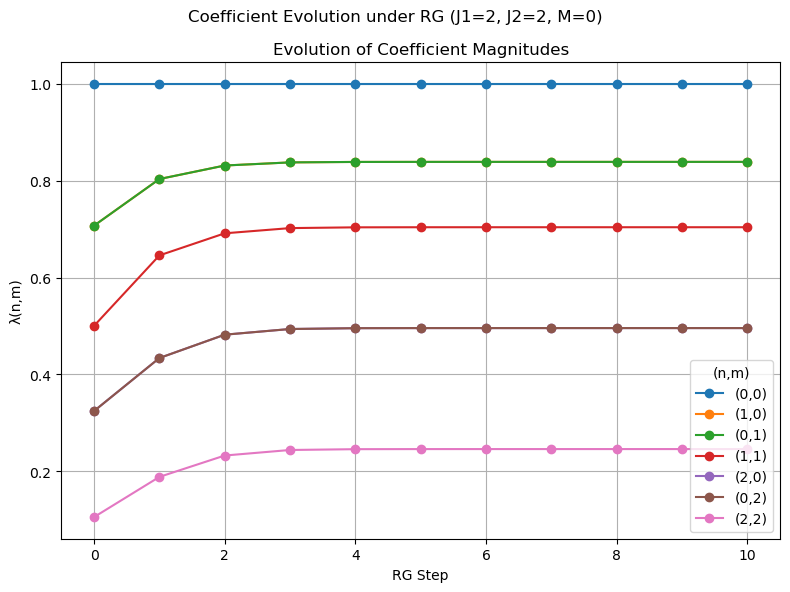

In [16]:
J1, J2, M = 2, 2, 0
H_s, H_t = 0, 0

b = 3
d = 2

n_max = 20
n_steps = 10

# Track RG flow
flow_history = track_rg_flow_with_fields(
    J1, J2, M, H_s, H_t, b=b, d=d, n_max=n_max, n_steps=n_steps)

print(f"J1 = {J1}, J2 = {J2}, M = {M}\nHs = {H_s}, Ht = {H_t}, M = {M}\n")
coefficient_sink(flow_history, rg_step=-1)

# Coefficient evolutionb
fig = plot_coefficient_evolution(flow_history, J1, J2, M)
#plt.savefig(f"coefficient_evolution_field_{H_s,H_t}.png")
plt.show()

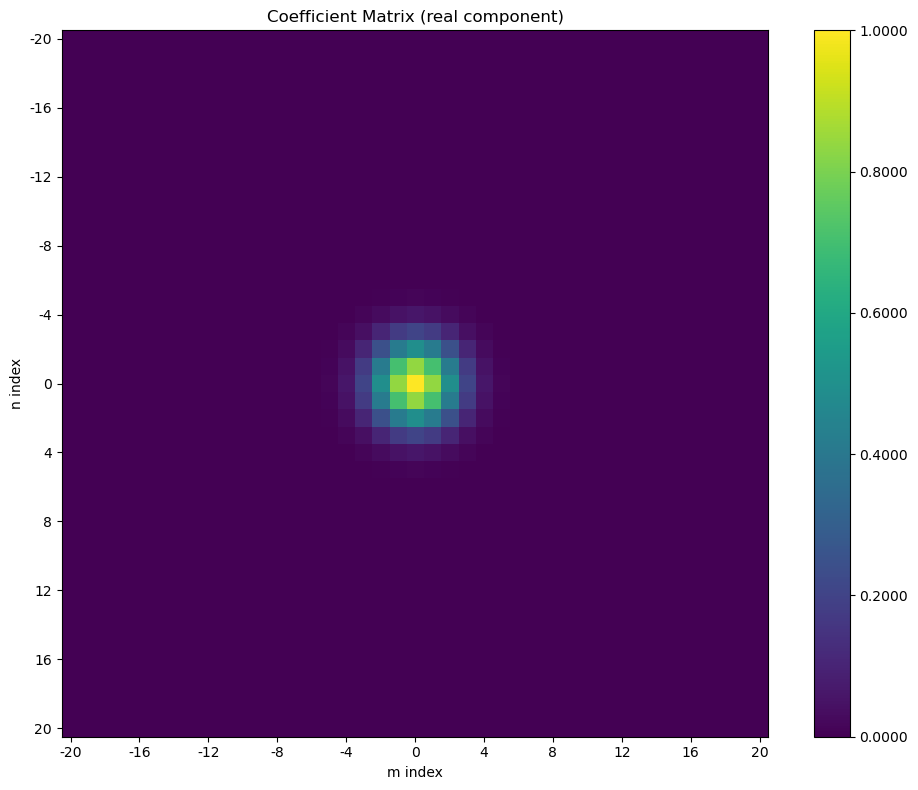

In [23]:
display_coefficient_matrix_colormap(
    flow_history[-1], decimals=4, component='real',
    save_path=None
)

# Phase diagram

In [41]:
import psutil
logical_cores = psutil.cpu_count(logical=True)
physical_cores = psutil.cpu_count(logical=False)
print(f"Number of logical cores: {logical_cores}")
print(f"Number of physical cores: {physical_cores}")

import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from lib.phase_parallel import generate_phase_diagram_joblib

import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

Number of logical cores: 8
Number of physical cores: 8


In [43]:
def identify_phase(J1, J2, M, H_s, H_t, n_max=10, n_rg_steps=20, b=2, d=2, history_length=3):
    """
    Identify phase based on coefficient patterns with early stopping when convergence is detected.
    Uses numpy implementation and includes external fields.

    Args:
        J1, J2, M: Model parameters
        H_s, H_t: External field strengths
        n_max: Maximum Fourier mode
        n_rg_steps: Maximum number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence

    Returns:
        String indicating the identified phase
    """
    e = 1e-3  # Threshold for both phase identification and convergence

    # Initialize coefficient array with external fields
    lambda_nm = get_initial_coefficients_with_fields(J1, J2, M, H_s, H_t, n_max)

    # Define coefficient keys to track
    coefficient_indices = [
        (n_max+1, n_max),    # coeff_10
        (n_max, n_max+1),    # coeff_01
        (n_max+1, n_max+1),  # coeff_11
        (n_max+2, n_max),    # coeff_20
        (n_max, n_max+2),    # coeff_02
        (n_max+2, n_max+2)   # coeff_22
    ]

    # Keep track of convergence status for each coefficient
    stable_iterations = {idx: 0 for idx in coefficient_indices}

    # Perform RG flow with convergence check
    prev_lambda_nm = None

    for i in range(n_rg_steps):
        lambda_nm = rg_step(lambda_nm, b, d)

        # Only start checking conditions after 6 iterations
        if i >= 5:  # This ensures the loop runs at least 6 times (i = 0, 1, 2, 3, 4, 5)
            # Check if the disordered phase is reached
            all_near_zero = True
            for n_idx, m_idx in coefficient_indices:
                coeff_value = lambda_nm[n_idx, m_idx].real
                if abs(coeff_value) >= e:
                    all_near_zero = False
                    break

            if all_near_zero:
                return "D_Phase"  # Early detection of disordered phase

            # Check for convergence if we have a previous state to compare with
            if prev_lambda_nm is not None:
                all_converged = True

                for n_idx, m_idx in coefficient_indices:
                    current_val = lambda_nm[n_idx, m_idx].real
                    prev_val = prev_lambda_nm[n_idx, m_idx].real

                    # Calculate difference between iterations
                    diff = abs(current_val - prev_val)

                    if diff < e:
                        stable_iterations[(n_idx, m_idx)] += 1
                    else:
                        stable_iterations[(n_idx, m_idx)] = 0
                        all_converged = False

                # Break if all coefficients have been stable for enough iterations
                if all_converged and all(count >= history_length-1 for count in stable_iterations.values()):
                    break

        # Store current state for next iteration
        prev_lambda_nm = lambda_nm.copy()

    # Extract final coefficients
    coeff_10 = lambda_nm[n_max+1, n_max].real
    coeff_01 = lambda_nm[n_max, n_max+1].real
    coeff_11 = lambda_nm[n_max+1, n_max+1].real
    coeff_20 = lambda_nm[n_max+2, n_max].real
    coeff_02 = lambda_nm[n_max, n_max+2].real
    coeff_22 = lambda_nm[n_max+2, n_max+2].real
    
    # Check for magnetization (effect of external fields)
    coeff_10_imag = lambda_nm[n_max+1, n_max].imag
    coeff_01_imag = lambda_nm[n_max, n_max+1].imag
    has_magnetization = (abs(coeff_10_imag) > e or abs(coeff_01_imag) > e)

    # Phase conditions
    if (abs(coeff_10) < e and  # (1,0) = 0
        abs(coeff_01) < e and  # (0,1) = 0
        abs(coeff_11) < e and  # (1,1) = 0
        abs(coeff_20) < e and  # (2,0) = 0
        abs(coeff_02) < e and  # (0,2) = 0
        abs(coeff_22) < e):    # (2,2) = 0
        return "D_Phase"  # Disordered
    
    elif (coeff_10 > e and  # (1,0) > 0
          coeff_01 > e and  # (0,1) > 0
          coeff_11 > e and  # (1,1) > 0
          coeff_20 > e and  # (2,0) > 0
          coeff_02 > e and  # (0,2) > 0
          coeff_22 > e):    # (2,2) > 0
        return "F_Phase" if not has_magnetization else "FM_Phase"  # Ferromagnetic (with/without magnetization)
    
    elif (abs(coeff_10) < e and  # (1,0) = 0
          abs(coeff_01) < e and  # (0,1) = 0
          coeff_11 > e and       # (1,1) > 0
          coeff_20 > e and       # (2,0) > 0
          coeff_02 > e and       # (0,2) > 0
          coeff_22 > e):         # (2,2) > 0
        return "Fs_Phase" if not has_magnetization else "FsM_Phase"  # Locked Ferromagnetic
    
    elif (coeff_10 < -e and  # (1,0) < 0
          coeff_01 < -e and  # (0,1) < 0
          coeff_11 > e and   # (1,1) > 0
          coeff_20 > e and   # (2,0) > 0
          coeff_02 > e and   # (0,2) > 0
          coeff_22 > e):     # (2,2) > 0
        return "A_Phase" if not has_magnetization else "AM_Phase"  # Antiferromagnetic
    
    elif (abs(coeff_10) < e and  # (1,0) = 0
          abs(coeff_01) < e and  # (0,1) = 0
          coeff_11 < -e and      # (1,1) < 0
          coeff_20 > e and       # (2,0) > 0
          coeff_02 > e and       # (0,2) > 0
          coeff_22 > e):         # (2,2) > 0
        return "As_Phase" if not has_magnetization else "AsM_Phase"  # Locked Antiferromagnetic
    
    else:
        return "X_Phase"  # Unknown phase

def generate_phase_diagram_with_fields_joblib(J_values, M_values, H_s, H_t=0.0, 
                                             n_max=10, n_rg_steps=20, b=2, d=2, 
                                             history_length=3, n_jobs=-1):
    """
    Generate phase diagram by scanning J, M parameter space using parallel processing with joblib.
    Includes external fields H_s and H_t.

    Args:
        J_values: Array of J values (J1=J2=J)
        M_values: Array of M values
        H_s: External field for s spins
        H_t: External field for t spins (default: 0.0)
        n_max: Maximum Fourier mode
        n_rg_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        n_jobs: Number of parallel jobs (default: -1 uses all cores)

    Returns:
        Tuple of phase points (D_Phase, F_Phase, A_Phase, Fs_Phase, As_Phase, X_Phase, 
                              FM_Phase, AM_Phase, FsM_Phase, AsM_Phase)
    """
    # Function to process one point in parameter space
    def process_one_point(J, M):
        J1 = J2 = J
        phase = identify_phase(J1, J2, M, H_s, H_t, n_max=n_max, 
                               n_rg_steps=n_rg_steps, b=b, d=d, 
                               history_length=history_length)
        return J, M, phase

    # Create list of all parameter combinations
    total_points = len(J_values) * len(M_values)
    print(f"Starting calculation for {total_points} points with {n_jobs} jobs")
    print(f"External fields: H_s = {H_s}, H_t = {H_t}")

    # Process all points in parallel
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_one_point)(J, M)
        for J in J_values
        for M in M_values
    )

    # Organize results into phase groups
    D_Phase, F_Phase, A_Phase, Fs_Phase, As_Phase = [], [], [], [], []
    FM_Phase, AM_Phase, FsM_Phase, AsM_Phase = [], [], [], []
    X_Phase = []

    for J, M, phase in results:
        if phase == "D_Phase":
            D_Phase.append([J, M])
        elif phase == "F_Phase":
            F_Phase.append([J, M])
        elif phase == "A_Phase":
            A_Phase.append([J, M])
        elif phase == "Fs_Phase":
            Fs_Phase.append([J, M])
        elif phase == "As_Phase":
            As_Phase.append([J, M])
        elif phase == "FM_Phase":  # Magnetized ferromagnetic
            FM_Phase.append([J, M])
        elif phase == "AM_Phase":  # Magnetized antiferromagnetic
            AM_Phase.append([J, M])
        elif phase == "FsM_Phase":  # Magnetized locked ferromagnetic
            FsM_Phase.append([J, M])
        elif phase == "AsM_Phase":  # Magnetized locked antiferromagnetic
            AsM_Phase.append([J, M])
        else:
            X_Phase.append([J, M])

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define color map for phases
    phase_colors = {
        "D_Phase": "gray",
        "F_Phase": "blue",
        "A_Phase": "red",
        "Fs_Phase": "green",
        "As_Phase": "orange",
        "FM_Phase": "cyan",   # Magnetized versions get different colors
        "AM_Phase": "magenta",
        "FsM_Phase": "lime",
        "AsM_Phase": "yellow",
        "X_Phase": "black"
    }
    
    # Calculate marker size based on grid size
    grid_size = len(J_values) * len(M_values)
    base_marker_size = 25  # Base size for a 10x10 grid
    reference_grid_size = 100
    ms = base_marker_size * np.sqrt(reference_grid_size / grid_size)
    ms = max(1, min(ms, 12))  # Limit between 1 and 12

    # Plot each phase
    phase_groups = [
        (D_Phase, "D_Phase", "Disordered"),
        (F_Phase, "F_Phase", "Ferromagnetic"),
        (A_Phase, "A_Phase", "Antiferromagnetic"),
        (Fs_Phase, "Fs_Phase", "Locked Ferromagnetic"),
        (As_Phase, "As_Phase", "Locked Antiferromagnetic"),
        (FM_Phase, "FM_Phase", "Magnetized Ferromagnetic"),
        (AM_Phase, "AM_Phase", "Magnetized Antiferromagnetic"),
        (FsM_Phase, "FsM_Phase", "Magnetized Locked Ferromagnetic"),
        (AsM_Phase, "AsM_Phase", "Magnetized Locked Antiferromagnetic"),
        (X_Phase, "X_Phase", "Unknown")
    ]
    
    # Plot points and create legend entries
    handles = []
    for points, phase_key, phase_label in phase_groups:
        if points:
            scatter = ax.scatter(
                np.array(points)[:,0], 
                np.array(points)[:,1],
                color=phase_colors[phase_key],
                marker="s",
                s=ms,
                alpha=1.0,
                label=phase_label
            )
            handles.append(scatter)
    
    # Add legend if any phases were plotted
    if handles:
        ax.legend(handles=handles, title="Phases")
    
    # Set labels and title
    ax.set_xlabel("J (Two-Spin Interaction)")
    ax.set_ylabel("M (Four-Spin Interaction)")
    ax.set_title(f"Phase Diagram with External Fields H_s={H_s}, H_t={H_t}")
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return (D_Phase, F_Phase, A_Phase, Fs_Phase, As_Phase, 
            FM_Phase, AM_Phase, FsM_Phase, AsM_Phase, X_Phase, fig)

def scan_external_field_joblib(J, M, H_s_values, H_t=0.0, 
                              n_max=10, n_rg_steps=20, b=2, d=2, 
                              history_length=3, n_jobs=-1):
    """
    Generate phase diagram by scanning external field H_s using parallel processing.

    Args:
        J: Two-spin interaction (J1=J2=J)
        M: Four-spin interaction
        H_s_values: Array of H_s values to scan
        H_t: External field for t spins (default: 0.0)
        n_max: Maximum Fourier mode
        n_rg_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        n_jobs: Number of parallel jobs (default: -1 uses all cores)

    Returns:
        Dictionary mapping phase names to lists of H_s values
    """
    # Function to process one point in parameter space
    def process_one_point(H_s):
        J1 = J2 = J
        phase = identify_phase_numpy(J1, J2, M, H_s, H_t, n_max=n_max, 
                                    n_rg_steps=n_rg_steps, b=b, d=d, 
                                    history_length=history_length)
        return H_s, phase

    # Process all points in parallel
    print(f"Scanning {len(H_s_values)} H_s values for J={J}, M={M}, H_t={H_t}")
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_one_point)(H_s)
        for H_s in H_s_values
    )

    # Organize results into phase groups
    phase_points = {
        "D_Phase": [], "F_Phase": [], "A_Phase": [], "Fs_Phase": [], "As_Phase": [],
        "FM_Phase": [], "AM_Phase": [], "FsM_Phase": [], "AsM_Phase": [], "X_Phase": []
    }

    for H_s, phase in results:
        phase_points[phase].append(H_s)

    # Plot the results
    plt.figure(figsize=(12, 6))
    
    phase_colors = {
        "D_Phase": "gray",
        "F_Phase": "blue",
        "A_Phase": "red",
        "Fs_Phase": "green",
        "As_Phase": "orange",
        "FM_Phase": "cyan",
        "AM_Phase": "magenta",
        "FsM_Phase": "lime",
        "AsM_Phase": "yellow",
        "X_Phase": "black"
    }
    
    # Plot a line indicating the range of H_s values
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(min(H_s_values), max(H_s_values))
    
    # Plot points for each phase
    for phase, points in phase_points.items():
        if points:
            plt.scatter(points, [0]*len(points), color=phase_colors[phase], 
                       label=phase, s=50, alpha=0.8)
    
    # Add labels and legend
    plt.xlabel("External Field H_s")
    plt.title(f"Phase Diagram vs External Field (J={J}, M={M}, H_t={H_t})")
    plt.legend(title="Phases")
    plt.tight_layout()
    
    return phase_points, plt

Starting calculation for 144 points with -1 jobs
External fields: H_s = 0.1, H_t = 0.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.1min finished


ValueError: too many values to unpack (expected 2)

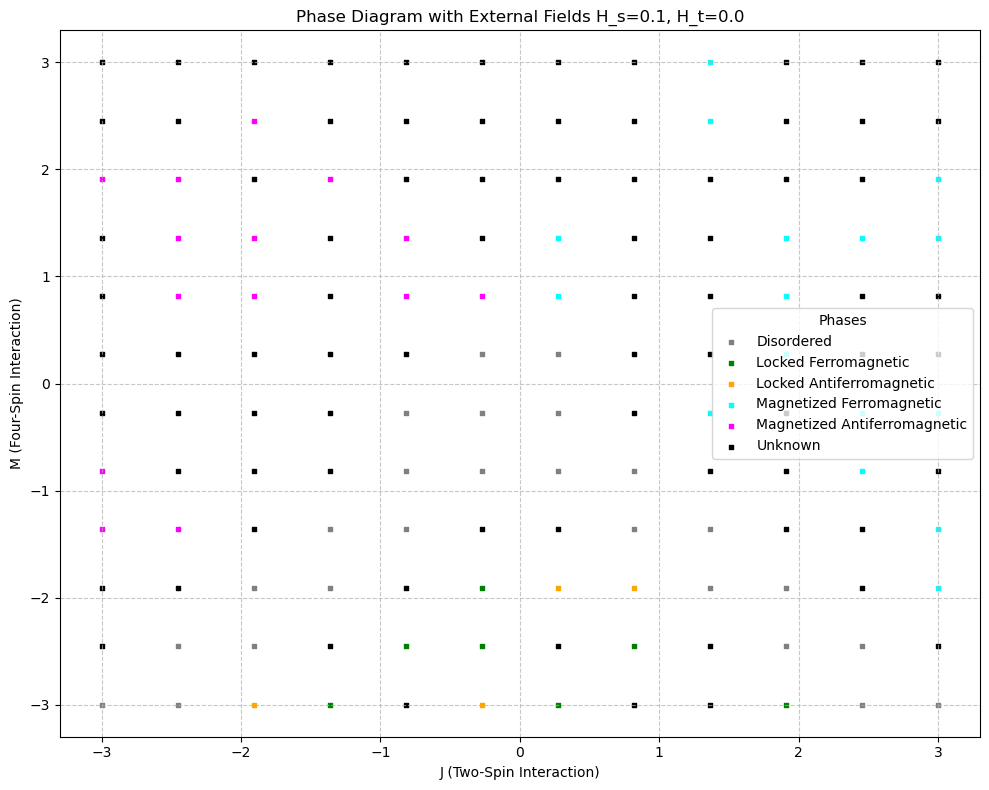

In [45]:
J_values = np.linspace(-3, 3, 12)
M_values = np.linspace(-3, 3, 12)

# External fields
H_s = 0.1
H_t = 0.0

# Generate phase diagram
phase_points, fig = generate_phase_diagram_with_fields_joblib(
    J_values, M_values, H_s, H_t, 
    n_max=20, n_rg_steps=10, b=3, d=2,
    n_jobs=-1
)

# Save and show the plot
#fig.savefig(f"phase_diagram_Hs_{H_s}_Ht_{H_t}.png", dpi=300)
plt.show()

In [ ]:

# Scan external field for specific J, M values
J = 1.0
M = 0.5
H_s_values = np.linspace(-1.0, 1.0, 21)

# Generate external field scan
phase_vs_field, plot = scan_external_field_joblib(
    J, M, H_s_values, H_t=0.0,
    n_max=10, n_rg_steps=20, b=3, d=2,
    n_jobs=4
)

# Save and show the plot
plt.savefig(f"field_scan_J_{J}_M_{M}.png", dpi=300)
plt.show()


In [ ]:
# Define parameter ranges
n_points = 22
J_values = np.linspace(start=-.25, stop=0, num=n_points)
M_values = np.linspace(start=1, stop=3, num=n_points)

start_time = time.time()
# Run the calculation
D_Phase, A_Phase, B_Phase, C_Phase, E_Phase, X_Phase, U_Phase = generate_phase_diagram_joblib(
    J_values,
    M_values,
    n_max_np=20,
    n_max_mp=10,
    n_rg_steps=45,
    b=3,
    d=2,
    history_length=3,
    dps=100,
    path=f"phase_diagram_JM_{n_points}",
    n_jobs=physical_cores,
    only_mp=True)

end_time = time.time()
secs = end_time - start_time
print(f"""
Calculation completed in:
- {secs:.2f} seconds
- {secs / 60:.2f} minutes
- {secs / 60 / 60:.2f} hours
- {secs / 60 / 60 / 24:.2f} days
""")